In [ ]:
# import os
# import shutil
# import numpy as np

# # Base directory where the current class directories are located
# base_dir = 'E:\\Brain_tumor\\Tumor'

# # Define the split sizes
# split_train = 0.7
# split_val = 0.15
# split_test = 0.15

# # Create directories for train, validation, and test sets
# for split in ['train', 'val', 'test']:
#     for tumor_class in ['glioma', 'meningioma', 'pituitary tumor']:
#         os.makedirs(os.path.join(base_dir, split, tumor_class), exist_ok=True)

# # Function to split and distribute the images
# def distribute_files(class_dir, split_train, split_val, split_test):
#     # List all files in the directory
#     all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
#     np.random.shuffle(all_files)  # Shuffle the file list

#     # Calculate split indices
#     train_end = int(len(all_files) * split_train)
#     val_end = train_end + int(len(all_files) * split_val)

#     # Split files
#     train_files = all_files[:train_end]
#     val_files = all_files[train_end:val_end]
#     test_files = all_files[val_end:]

#     # Function to copy files to a destination directory
#     def copy_files(files, dest_dir):
#         for f in files:
#             shutil.copy(os.path.join(class_dir, f), os.path.join(dest_dir, f))

#     # Copy files to their respective directories
#     copy_files(train_files, os.path.join(base_dir, 'train', tumor_class))
#     copy_files(val_files, os.path.join(base_dir, 'val', tumor_class))
#     copy_files(test_files, os.path.join(base_dir, 'test', tumor_class))

# # Distribute files for each tumor class
# for tumor_class in ['glioma', 'meningioma', 'pituitary tumor']:
#     class_dir = os.path.join(base_dir, tumor_class)
#     distribute_files(class_dir, split_train, split_val, split_test)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your image size and batch size
image_size = (256, 256)  # Adjust according to your U-Net model's input
batch_size = 16 # Adjust based on your system's capabilities

# Create an ImageDataGenerator for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=10,  # Random rotations
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    vertical_flip=True,  # Random vertical flips
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Create an ImageDataGenerator for the validation and test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Define the paths to your train, validation, and test directories
base_dir = '/content/drive/My Drive/Tumor'
train_dir = '/content/drive/My Drive/Tumor/train'
val_dir = '/content/drive/My Drive/Tumor/val'
test_dir = '/content/drive/My Drive/Tumor/test'

# Create generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' if you have two classes, 'categorical' for multi-class
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2784 images belonging to 3 classes.
Found 844 images belonging to 3 classes.
Found 857 images belonging to 3 classes.


In [ ]:
!pip install tensorflow-hub


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub  # For loading pre-trained Vision Transformer


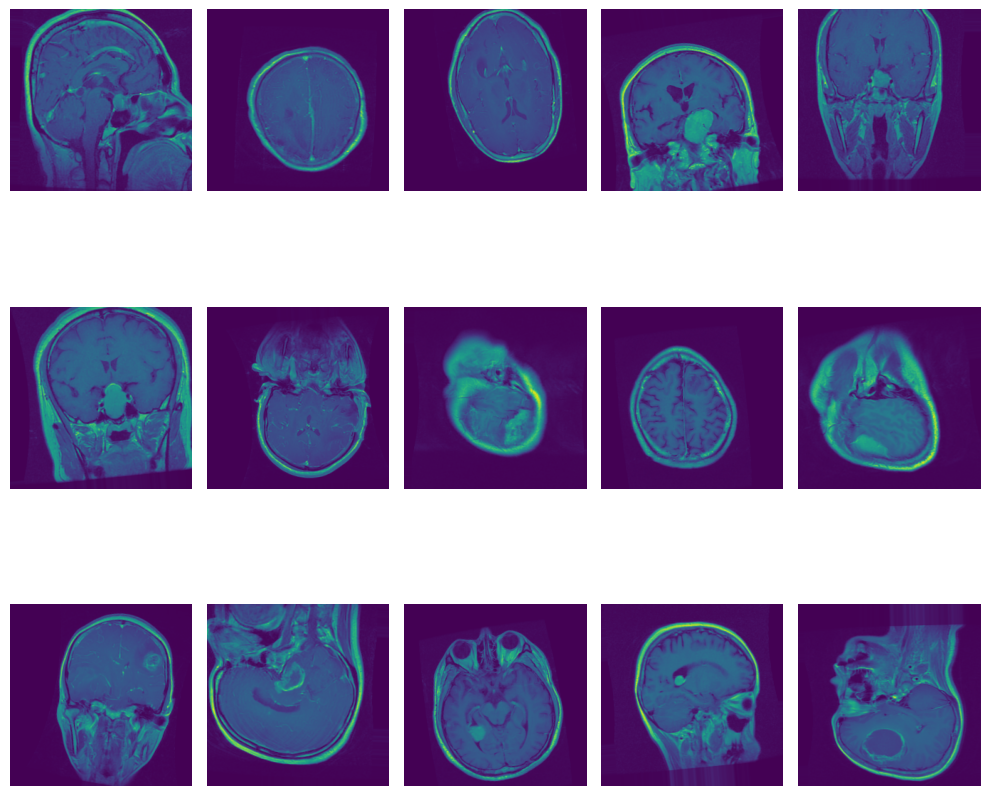

In [ ]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

images = [train_generator[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()
# plt.imshow(train_generator[0][0][0])

In [ ]:
!pip install vit_keras

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
!pip install tensorflow-addons

from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.2 MB/s eta 0:00:00
347502902/347502902 [==============================] - 1s 0us/step


In [ ]:
import tensorflow.keras.layers as L
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: (256, 256) X (256, 256)
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


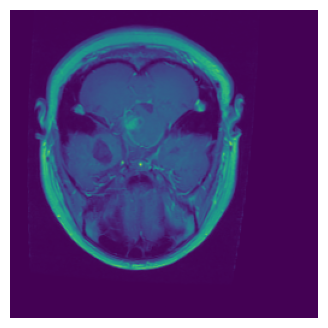

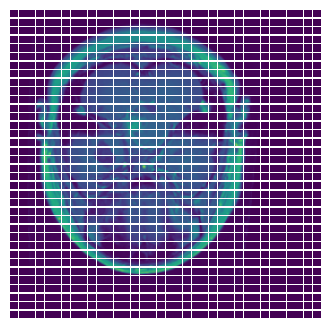

In [ ]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (256 // patch_size) ** 2

x = train_generator.next()
image = x[0][0]

plt.imshow(image)
plt.axis('off')

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size = (image_size, image_size)
# )

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (256, 256)
)

patches = Patches(patch_size)(resized_image)
# patches = Patches(patch_size)(image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

In [ ]:
import tensorflow_addons as tfa
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint path and filenames
checkpoint_path = "/content/drive/My Drive/Tumor/models/checkpoint.ckpt"

# Create a callback that saves the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [ ]:
# warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID ,
          epochs = 50,)

Epoch 1/50
174/174 [==============================] - 1097s 6s/step - loss: 0.8848 - accuracy: 0.6818 - val_loss: 0.7166 - val_accuracy: 0.8101
Epoch 2/50
174/174 [==============================] - 176s 1s/step - loss: 0.7065 - accuracy: 0.8409 - val_loss: 0.6576 - val_accuracy: 0.8858
Epoch 3/50
174/174 [==============================] - 176s 1s/step - loss: 0.6334 - accuracy: 0.9088 - val_loss: 0.5990 - val_accuracy: 0.9243
Epoch 4/50
174/174 [==============================] - 175s 1s/step - loss: 0.6139 - accuracy: 0.9159 - val_loss: 0.6200 - val_accuracy: 0.9002
Epoch 5/50
174/174 [==============================] - 175s 1s/step - loss: 0.5876 - accuracy: 0.9371 - val_loss: 0.6281 - val_accuracy: 0.9014
Epoch 6/50
174/174 [==============================] - 179s 1s/step - loss: 0.5795 - accuracy: 0.9379 - val_loss: 0.6453 - val_accuracy: 0.8906
Epoch 7/50
174/174 [==============================] - 175s 1s/step - loss: 0.5715 - accuracy: 0.9432 - val_loss: 0.5228 - val_accuracy: 0.982

In [ ]:
model.save('/content/drive/My Drive/Tumor/ my_model.h5')
# import tensorflow as tf
# model = tf.keras.models.load_model(checkpoint_path )